<a href="https://colab.research.google.com/github/lorransr/warpage_analysis/blob/master/warpage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prevendo rechupe

## Descrição dos Dados
Os dados utilizado neste trabalho são baseados no artigo de [Taghizadeh](http://jps.shirazu.ac.ir/article_1744_b7eb8ed50d88a80fe3a7ade4b30059fb.pdf), que buscou prever o rechupe em uma peça circular de plástico, concebida pelo processo de injeção sob diversos parâmetros. Para obtenção dos dados Taghizadeh, utilizou o Moldflow Plastics Insight (MPI).
A princípio foi concebido o desenho 3D de uma peça com geometria similar a calços, espaçadores automotivos, transmissão e geração de energia. A peça em questão foi escolhida, justamente, por conta da importância que a sua forma final em relação ao seu desempenho. O plástico utilizado na simulação foi o Polietileno de baixa densidade (LDPE), com as seguintes propriedades:

* Temperatura de Injeção (°C): 180~280
* Temperatura do Molde (°C): 20~70
* Condutividade Térmica (W/m°C): 0.31
* Calor Específico(J/kg°C): 3400

O modelo foi importado para o MPI e em seguida foi aplicada uma malha, antes de se realizar a análise. Foi escolhida uma malha de elementos triangulares. O tipo de malha foi a malha para superfícies fundidas. De maneira que ao fim do processo foram obtidos 1174 nós, com 2204 elementos triangulares, e com Match ratio (**entender oq é**) de 97%. 
Vale ressaltar que foram também simulados canais de resfriamento situados a 15 mm da superfície da peça e com distâncias entre canais de 55mm.

Ao todo foram selecionados para a simulação cinco níveis de temperatura de injeção (280,255,230,205 e 180°C), três níveis da pressão de recalque(90,75 e 60% da pressão máxima de injeção), três níveis de  temperatura do molde (70,45 e 20°C). A partir desses valores foi criado um conjunto de dados de treino, com 45 configurações, utilizando-se o método fatorial de design de experimento. A numeração de cada teste foi realizada de acordo com o nível de cada parâmetro. Foi convencionado o  número 1 para o nível mais baixo, 2 para o segundo nível e assim sucessivamente até o nível mais alto. De tal forma que para o teste T-523, o digito 4 indica o quarto nível da temperatura de injeção(280), 2 indica o segundo nível da pressão de recalque (75% da pressão de injeção), e 3 indica o terceiro nível da temperatura do molde (70).Em seguida foi simulado também um conjunto de teste contendo 10 amostras com valores aleatórios de parâmetros dentro das faixas recomendadas.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt

In [0]:
#Importando os dados
url = "https://raw.githubusercontent.com/lorransr/warpage_analysis/master/warpage.csv"
raw = pd.read_csv(url,sep = ";")

In [36]:
raw.head()

,teste,melt_temp,hold_press,mold_temp,warpage
0,T-111,180,60,20,1.328
1,T-112,180,60,45,1.328
2,T-113,180,60,70,1.310
3,T-121,180,75,20,0.981
4,T-122,180,75,45,0.989


In [37]:
raw.dtypes

teste          object
melt_temp       int64
hold_press      int64
mold_temp       int64
warpage       float64
dtype: object

In [0]:
df = raw

## Analise Exploratória

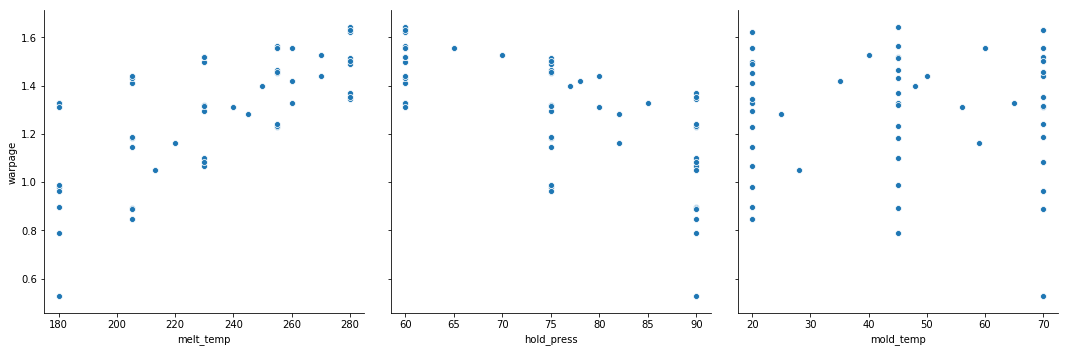

In [99]:
g = sns.pairplot(df,x_vars = df.columns[1:4], y_vars = "warpage", height = 5)

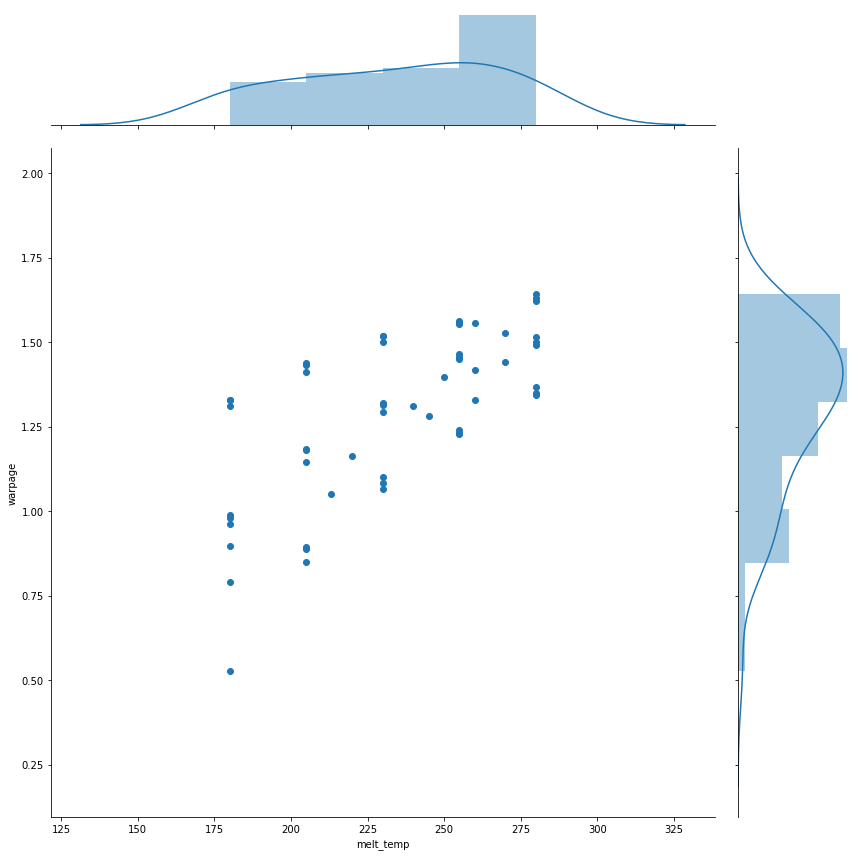

In [100]:


grid = sns.JointGrid( "melt_temp","warpage", data = df,height = 12)

grid.plot_joint(plt.scatter)
grid.plot_marginals(sns.distplot)

## Separando o dataframe de treino e o dataframe de teste

Os primeiros 45 valores são referentes ao valores de treino e os ultimos 10 aos valores de teste. Sendo assim, basta separa-los.

In [0]:
#Ultimos 10 linhas
X_test = raw.drop("warpage",axis=1).tail(10)
X_test.set_index("teste",inplace = True)

In [0]:
#primeiros 45 linhas
X_train =  raw.drop("warpage",axis=1).head(45)
X_train.set_index("teste",inplace= True)

In [0]:
y_test=raw["warpage"].tail(10).to_numpy()
y_train=raw["warpage"].head(45).to_numpy()

## Pré Processamento

A rede neural em Python pode ter algumas dificuldades em covergir antes do número máximo de interações permitidas se os dados não estiverem normalizados. O perceptron de multiplas-camadas é sensivel a escala das features, dessa forma é recomendavel que elas estejam normalizadas. Uma vez que os dados não possuem outliers, o StandardScaler do próprio scikit-learn é uma ferramenta adequada para a normalização dos dados.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [44]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Criando o regressor

In [0]:
from sklearn.neural_network import MLPRegressor

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(5,3),
                   max_iter=700,
                   solver = "lbfgs",
                   random_state = 42)

In [48]:
mlp.fit(X_train,y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(5, 3), learning_rate='constant',
             learning_rate_init=0.001, max_iter=700, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:
predictions_test = mlp.predict(X_test)
predictions_train = mlp.predict(X_train)

In [50]:
predictions_test

array([1.43578665, 1.51975274, 1.54105277, 1.42460129, 1.34500927,
       1.41011028, 1.29834162, 1.3331364 , 0.95444932, 1.1481733 ])

In [51]:
y_test

array([1.44 , 1.527, 1.557, 1.417, 1.328, 1.396, 1.28 , 1.312, 1.05 ,
       1.162])

In [52]:
from sklearn import metrics

metrics.r2_score(y_test,predictions_test)

0.9503298709006565

In [53]:
metrics.r2_score(y_train,predictions_train)

0.9941764091705162

In [54]:
#The weight matrix at index i holds the weights between the layer i and layer i + 1. https://www.python-course.eu/images/mlp_example_layer.png
print("weights between input and first hidden layer:")
print(mlp.coefs_[0])
print("\nweights between first hidden and second hidden layer:")
print(mlp.coefs_[1])
print("\nweights between second hidden and result:")
print(mlp.coefs_[2])

weights between input and first hidden layer:
[[ 0.07001345  0.89787471 -0.32653017 -0.37640497 -0.83223389]
 [-0.63099473 -0.97344795  0.42708507  0.34677342  0.69222905]
 [-0.9073803   0.29512139  0.86688819 -0.17088574 -0.26087691]]

weights between first hidden and second hidden layer:
[[ 0.11234135 -0.28616841 -0.37218335]
 [ 0.36105603 -0.20679787  0.17747356]
 [-0.12967757  0.61806258  0.27368371]
 [-0.35675513 -0.15442684 -0.69582342]
 [-0.60760199  0.95991727  0.62966412]]

weights between second hidden and result:
[[ 0.2565208 ]
 [-0.0799621 ]
 [-0.95474526]]
